# Problem Description



**Problem Statement:** One of the challenge for all Pharmaceutical companies is to understand the persistency of drug as per the physician prescription. To solve this problem ABC pharma company approached an analytics company to automate this process of identification.

# Importing all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Loading dataset

In [2]:
# change to name of file
file_name = "dataglacierdataset.csv"
df = pd.read_csv(file_name)

# Data Understanding

In [3]:
df.shape

(3424, 69)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 69 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Ptid                                                                3424 non-null   object
 1   Persistency_Flag                                                    3424 non-null   object
 2   Gender                                                              3424 non-null   object
 3   Race                                                                3424 non-null   object
 4   Ethnicity                                                           3424 non-null   object
 5   Region                                                              3424 non-null   object
 6   Age_Bucket                                                          3424 non-null   object
 7   Ntm_Speciality          

In [ ]:
missing_values = df.isnull().sum()

missing_values_summary = pd.DataFrame({
    "Column": df.columns,
    "Missing Values": missing_values,
    "Percentage Missing": (missing_values / len(df)) * 100
}).sort_values(by="Percentage Missing", ascending=False)

print("Missing Values Summary:")
print(missing_values_summary)

Missing Values Summary:
                                                                                               Column  \
Ptid                                                                                             Ptid   
Concom_Cephalosporins                                                           Concom_Cephalosporins   
Risk_Osteogenesis_Imperfecta                                             Risk_Osteogenesis_Imperfecta   
Risk_Type_1_Insulin_Dependent_Diabetes                         Risk_Type_1_Insulin_Dependent_Diabetes   
Concom_Viral_Vaccines                                                           Concom_Viral_Vaccines   
...                                                                                               ...   
Comorb_Other_Joint_Disorder_Not_Elsewhere_Class...  Comorb_Other_Joint_Disorder_Not_Elsewhere_Clas...   
Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Sus...  Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Su...   
Comorb_Long_Term_Current_Drug_T

In [ ]:
df.isnull().sum().sum()

0

No null values in the dataset. It seems they set values to unknown instead of setting values to null to avoid any null values.

## Data Transformation

In [ ]:
df['Count_Of_Risks'] = pd.to_numeric(df['Count_Of_Risks'], errors='coerce').astype('Int64')

In [ ]:
df['Count_Of_Risks'].value_counts().sort_values(ascending=False)

,count
Count_Of_Risks,
1,1242
0,970
2,781
3,317
4,91
5,15
6,6
7,2


## Exploratory Data Analysis

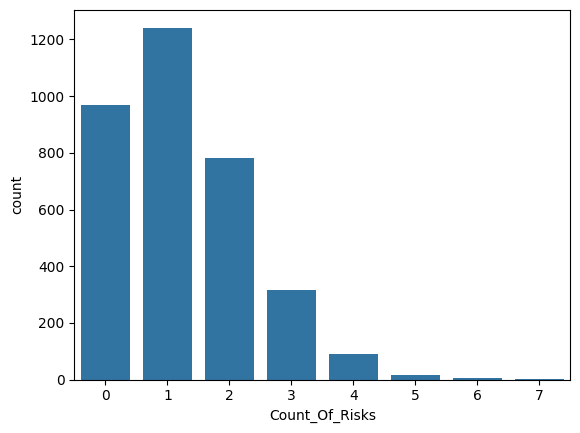

In [ ]:
g = sns.countplot(data=df, x='Count_Of_Risks')

As we can see, most people tend to have 0-2 counts of risk in total, which is good to see. It is better to see less counts of risks in comparison to the higher numbers.

In [ ]:
df['Dexa_Freq_During_Rx'].value_counts().sort_values(ascending=True)

,count
Dexa_Freq_During_Rx,
29,1
54,1
146,1
50,1
35,1
44,1
72,1
40,1
68,1


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
outliers_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"{col}: Found {len(outliers)} outliers")


Dexa_Freq_During_Rx: Found 460 outliers
Count_Of_Risks: Found 8 outliers


In [ ]:
from scipy.stats import skew

skewness = df[numeric_cols].apply(skew).sort_values(ascending=False)

print("Skewness in Numeric Columns:")
print(skewness)

for col in skewness[skewness > 1].index:
    df[col] = np.log1p(df[col])

Skewness in Numeric Columns:
Dexa_Freq_During_Rx    6.805747
Count_Of_Risks         0.879405
dtype: float64


In [ ]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head(5))
    print("-" * 50)

for col in df.columns:
    unknown_count = (df[col] == "Unknown").sum()
    if unknown_count > 0:
        print(f"{col}: {unknown_count} 'Unknown' entries")


Ptid: 3424 unique values
Ptid
P1       1
P2275    1
P2277    1
P2278    1
P2279    1
Name: count, dtype: int64
--------------------------------------------------
Persistency_Flag: 2 unique values
Persistency_Flag
Non-Persistent    2135
Persistent        1289
Name: count, dtype: int64
--------------------------------------------------
Gender: 2 unique values
Gender
Female    3230
Male       194
Name: count, dtype: int64
--------------------------------------------------
Race: 4 unique values
Race
Caucasian           3148
Other/Unknown         97
African American      95
Asian                 84
Name: count, dtype: int64
--------------------------------------------------
Ethnicity: 3 unique values
Ethnicity
Not Hispanic    3235
Hispanic          98
Unknown           91
Name: count, dtype: int64
--------------------------------------------------
Region: 5 unique values
Region
Midwest          1383
South            1247
West              502
Northeast         232
Other/Unknown      60
Name

In [ ]:
pd.set_option('display.max_rows', 1000)
df.dtypes

,0
Ptid,object
Persistency_Flag,object
Gender,object
Race,object
Ethnicity,object
Region,object
Age_Bucket,object
Ntm_Speciality,object
Ntm_Specialist_Flag,object
Ntm_Speciality_Bucket,object


<Axes: xlabel='Dexa_Freq_During_Rx', ylabel='count'>

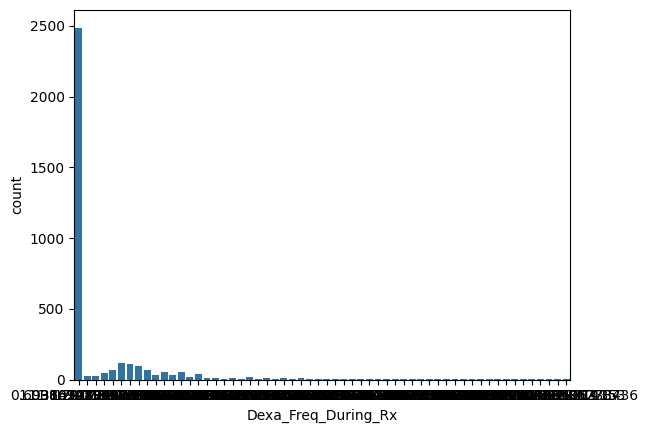

In [ ]:
g = sns.countplot(data=df,
                  x='Dexa_Freq_During_Rx')
g

<Axes: xlabel='Dexa_Freq_During_Rx', ylabel='count'>

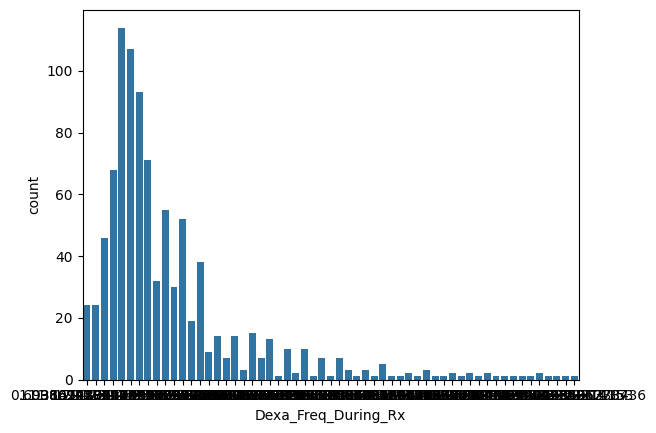

In [ ]:
g = sns.countplot(data=df[df['Dexa_Freq_During_Rx'] != 0],
                  x='Dexa_Freq_During_Rx')
g

This is what the distribution looks like without the outlier of 0

In [ ]:
df['Age_Bucket'].value_counts()

,count
Age_Bucket,
>75,1439
65-75,1086
55-65,733
<55,166


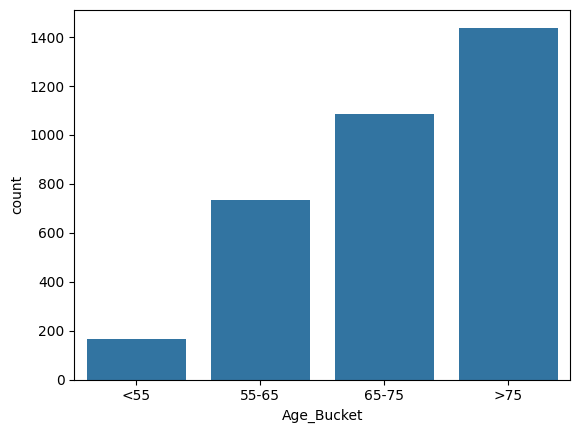

In [ ]:
g = sns.countplot(data=df,
                  x='Age_Bucket',
                  order=['<55', '55-65', '65-75', '>75']);

The largest proportion of patients reported in this dataset belongs to the older age group, specifically those aged >75.

In [ ]:
df['Ntm_Speciality_Bucket'].value_counts()

,count
Ntm_Speciality_Bucket,
OB/GYN/Others/PCP/Unknown,2104
Endo/Onc/Uro,716
Rheum,604


In [ ]:
df.rename(columns={'Ptid':'PatientID'}, inplace=True)

In [ ]:
df.Ethnicity.unique()

array(['Not Hispanic', 'Hispanic', 'Unknown'], dtype=object)

In [ ]:
df.Ethnicity.value_counts()

,count
Ethnicity,
Not Hispanic,3235
Hispanic,98
Unknown,91


In [ ]:
df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [ ]:
df.Region.unique()

array(['West', 'Midwest', 'South', 'Other/Unknown', 'Northeast'],
      dtype=object)

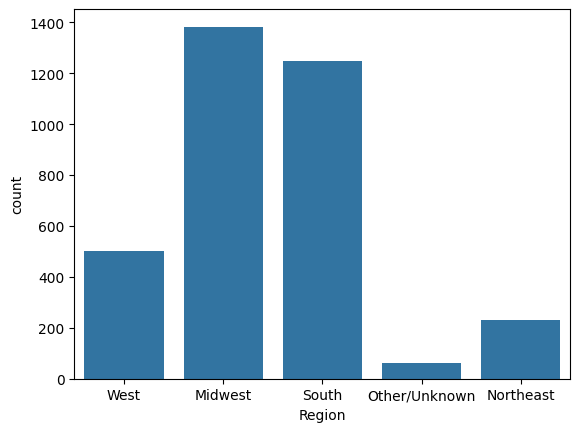

In [ ]:
g = sns.countplot(data = df,
                  x = df.Region);

Northeast and West seem to be severely underreported as compared to Midwest and South Region

In [ ]:
df.describe()

,Dexa_Freq_During_Rx,Count_Of_Risks
count,3424.000000,3424.0
mean,0.608034,1.239486
std,1.051456,1.094914
min,0.000000,0.0
25%,0.000000,0.0
50%,0.000000,1.0
75%,1.386294,2.0
max,4.990433,7.0


<Axes: xlabel='Tscore_Bucket_During_Rx', ylabel='count'>

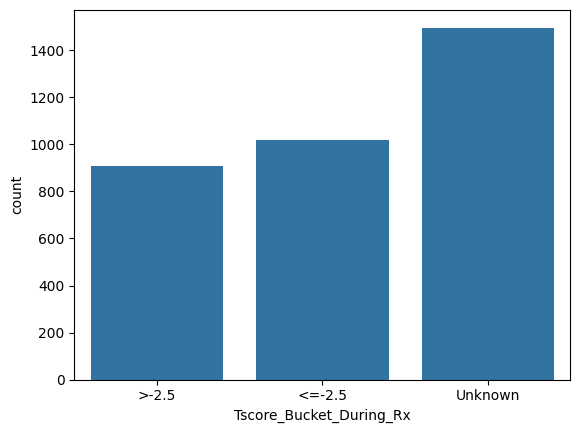

In [ ]:
g = sns.countplot(data = df,
                  x = df.Tscore_Bucket_During_Rx,
                  order=['>-2.5', '<=-2.5', 'Unknown'])
g

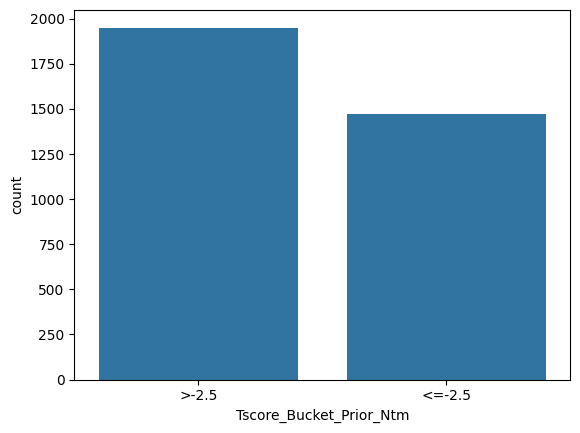

In [ ]:
g = sns.countplot(data = df,
                  x = df.Tscore_Bucket_Prior_Ntm,
                  order=['>-2.5', '<=-2.5'])
g;

In [ ]:
df.Change_T_Score.unique()

array(['No change', 'Unknown', 'Worsened', 'Improved'], dtype=object)

<Axes: xlabel='Change_T_Score', ylabel='count'>

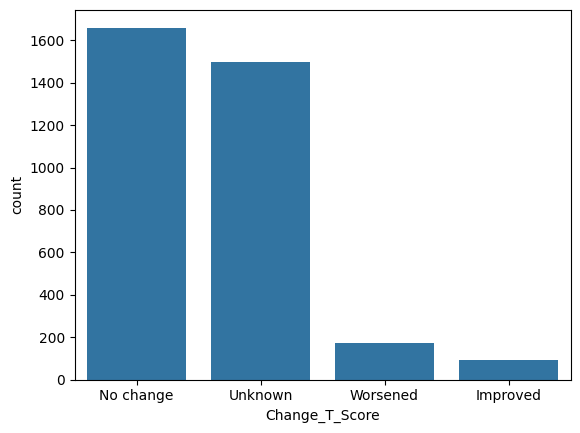

In [ ]:
g = sns.countplot(data = df,
                  x = df.Change_T_Score,
                  );
g

<Axes: xlabel='Change_Risk_Segment', ylabel='count'>

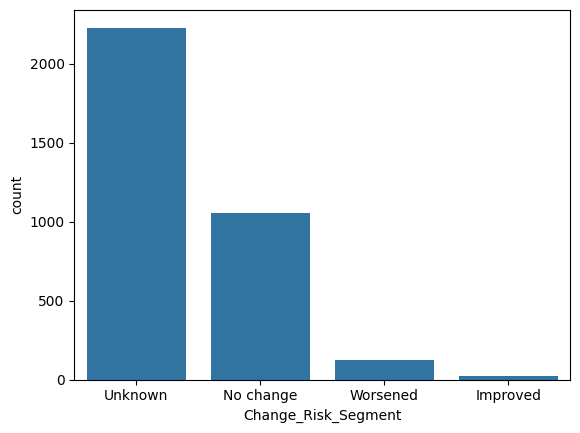

In [ ]:
g = sns.countplot(data = df,
                  x = df.Change_Risk_Segment,
                  );
g

We can see that typically there is no change. Worsened more than improved in terms of change risk segment.

Histogram for Count_Of_Risks

log transformation to Dexa_Freq_During_Rx for normalization

Histogram for normalized Dexa_Freq_During_Rx

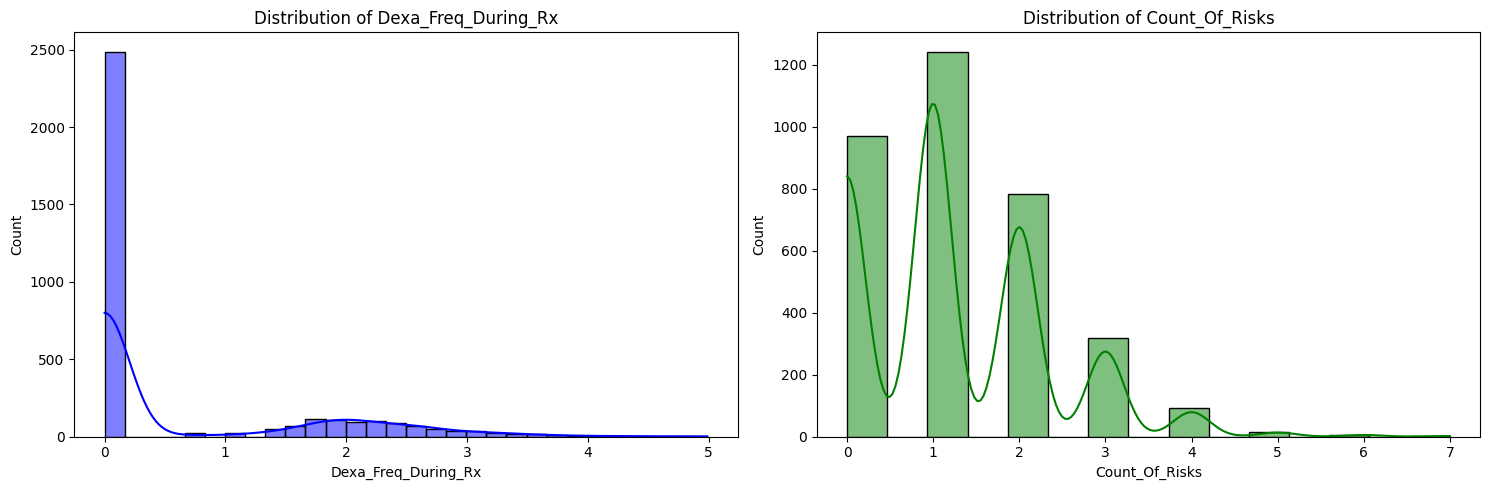

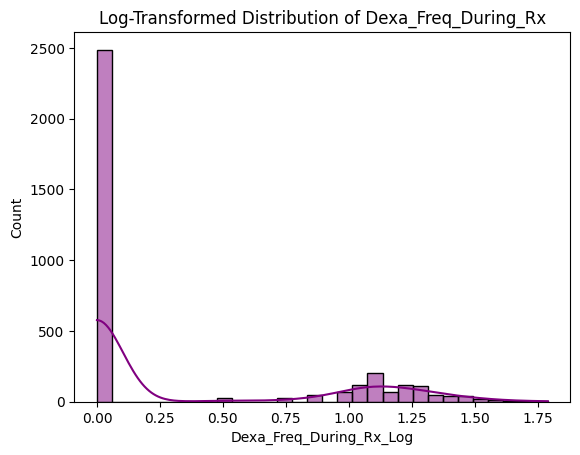

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['Dexa_Freq_During_Rx'], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Dexa_Freq_During_Rx")

sns.histplot(df['Count_Of_Risks'], bins=15, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Count_Of_Risks")

plt.tight_layout()
plt.show()

df['Dexa_Freq_During_Rx_Log'] = np.log1p(df['Dexa_Freq_During_Rx'])

sns.histplot(df['Dexa_Freq_During_Rx_Log'], bins=30, kde=True, color="purple")
plt.title("Log-Transformed Distribution of Dexa_Freq_During_Rx")
plt.show()



Convert Persistency_Flag to numerical for correlation

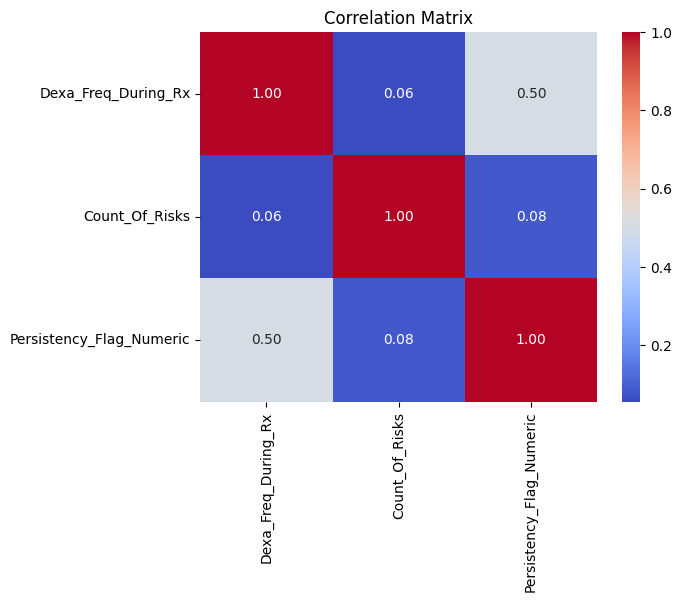

In [ ]:

df['Persistency_Flag_Numeric'] = df['Persistency_Flag'].map({'Persistent': 1, 'Non-Persistent': 0})

correlation = df[['Dexa_Freq_During_Rx', 'Count_Of_Risks', 'Persistency_Flag_Numeric']].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Categorical Feature Inspection: Ntm_Speciality and Gender and Gender Distribution

<ipython-input-34-5c96287ccb3d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Ntm_Speciality', order=df['Ntm_Speciality'].value_counts().index, ax=axes[0], palette="pastel")
<ipython-input-34-5c96287ccb3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Gender', ax=axes[1], palette="pastel")


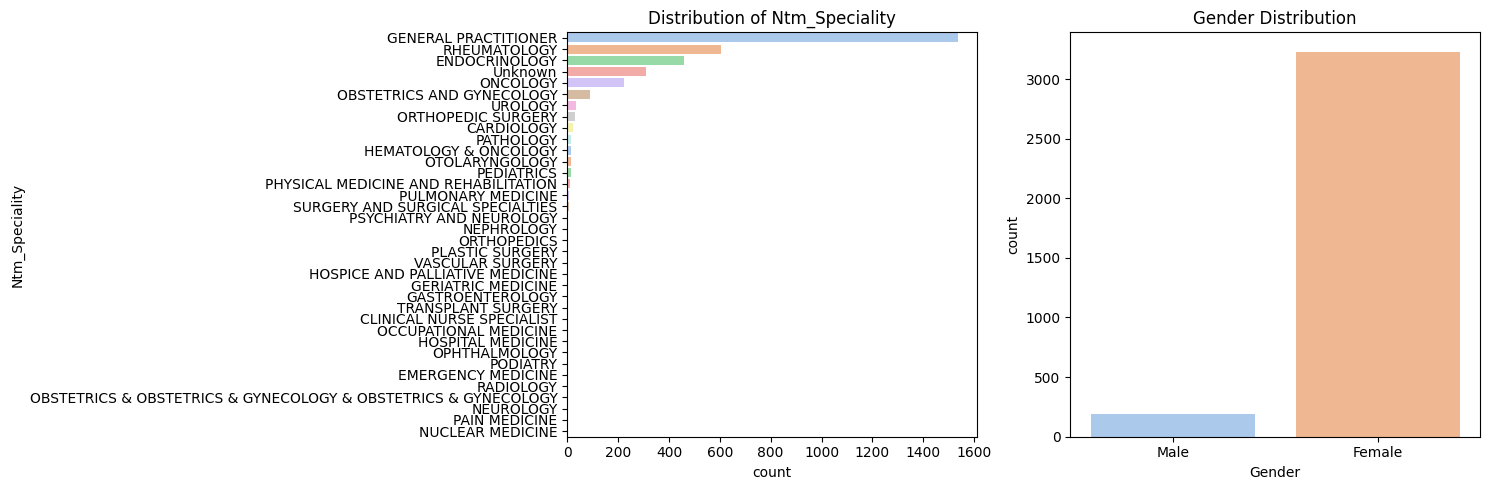

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df, y='Ntm_Speciality', order=df['Ntm_Speciality'].value_counts().index, ax=axes[0], palette="pastel")
axes[0].set_title("Distribution of Ntm_Speciality")

sns.countplot(data=df, x='Gender', ax=axes[1], palette="pastel")
axes[1].set_title("Gender Distribution")

plt.tight_layout()
plt.show()


Outlier Detection using IQR method

In [ ]:
outlier_info = {}

for column in ['Dexa_Freq_During_Rx', 'Count_Of_Risks']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_info[column] = outliers.shape[0]

for column in ['Dexa_Freq_During_Rx', 'Count_Of_Risks']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound,
                            np.where(df[column] > upper_bound, upper_bound, df[column]))

Handling Missing Values (categorical)

In [ ]:
missing_values = {col: (df[col] == "Unknown").sum() for col in df.columns if "Unknown" in df[col].unique()}
outlier_info, missing_values

({'Dexa_Freq_During_Rx': 42, 'Count_Of_Risks': 8},
 {'Ethnicity': 91,
  'Ntm_Speciality': 310,
  'Risk_Segment_During_Rx': 1497,
  'Tscore_Bucket_During_Rx': 1497,
  'Change_T_Score': 1497,
  'Change_Risk_Segment': 2229})

##Data Cleansing

I want to drop a couple outliers in order to see the distribution with other values

Devin Chau

Directly removed an outlier that we saw earlier through the EDA.

In [ ]:
df = df[df['Dexa_Freq_During_Rx'] != 0]

<Axes: xlabel='Dexa_Freq_During_Rx', ylabel='count'>

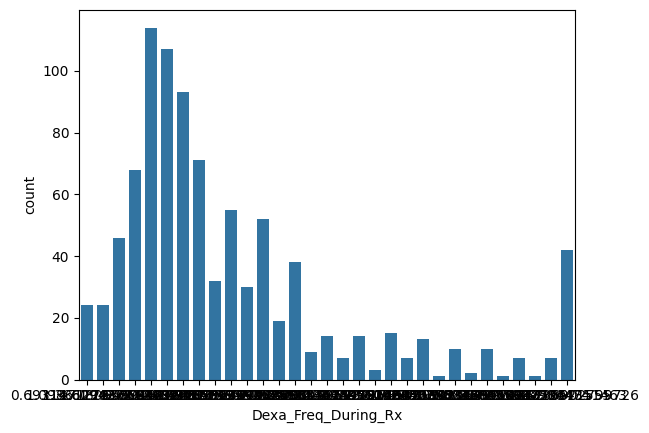

In [ ]:
g = sns.countplot(data=df,
                  x='Dexa_Freq_During_Rx')
g

Ethan Dy

Standardizing data types

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

df[categorical_cols] = df[categorical_cols].astype('category')

encoded_data = df.copy()
for col in categorical_cols:
    encoded_data[col] = encoded_data[col].cat.codes

Ethan Dy

Use MinMaxScalar to normalize and check for duplicate rows in the PatientID column

In [ ]:
risk_bins = [-1, 0, 2, 5, float('inf')]
risk_labels = ['None', 'Low', 'Moderate', 'High']
encoded_data['Risk_Level'] = pd.cut(encoded_data['Count_Of_Risks'].astype(int),
                                    bins=risk_bins,
                                    labels=risk_labels)


In [ ]:
scaler = MinMaxScaler()
encoded_data[numerical_cols] = scaler.fit_transform(encoded_data[numerical_cols])


In [ ]:
duplicates = df.duplicated(subset='PatientID').sum()

summary_stats = encoded_data.describe(include='all')

{
    "categorical_cols": categorical_cols,
    "numerical_cols": numerical_cols,
    "duplicates_found": duplicates,
    "summary_stats": summary_stats
}


{'categorical_cols': ['PatientID',
  'Persistency_Flag',
  'Gender',
  'Race',
  'Ethnicity',
  'Region',
  'Age_Bucket',
  'Ntm_Speciality',
  'Ntm_Specialist_Flag',
  'Ntm_Speciality_Bucket',
  'Gluco_Record_Prior_Ntm',
  'Gluco_Record_During_Rx',
  'Dexa_During_Rx',
  'Frag_Frac_Prior_Ntm',
  'Frag_Frac_During_Rx',
  'Risk_Segment_Prior_Ntm',
  'Tscore_Bucket_Prior_Ntm',
  'Risk_Segment_During_Rx',
  'Tscore_Bucket_During_Rx',
  'Change_T_Score',
  'Change_Risk_Segment',
  'Adherent_Flag',
  'Idn_Indicator',
  'Injectable_Experience_During_Rx',
  'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
  'Comorb_Encounter_For_Immunization',
  'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
  'Comorb_Vitamin_D_Deficiency',
  'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
  'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
  'Comorb_Long_Term_Current_Drug_Therapy',
  'Comorb_Dorsalgia',
  'Comorb_Personal_History_Of_Other_Diseases_And_C

Rohan Khatri

Using IQR as a method for handling outliers

In [ ]:
# Using IQR
Q1 = df['Dexa_Freq_During_Rx'].quantile(0.25)
Q3 = df['Dexa_Freq_During_Rx'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['Dexa_Freq_During_Rx_No_Outliers'] = np.where(
    df['Dexa_Freq_During_Rx'] > upper_bound, upper_bound,
    np.where(df['Dexa_Freq_During_Rx'] < lower_bound, lower_bound, df['Dexa_Freq_During_Rx'])
)
df['Dexa_Freq_During_Rx_No_Outliers'].describe()


,Dexa_Freq_During_Rx_No_Outliers
count,936.000000
mean,2.203513
std,0.616475
min,0.693147
25%,1.791759
50%,2.079442
75%,2.564949
max,3.465736


In [ ]:
df['Dexa_Freq_During_Rx_winsorize'] = winsorize(df['Dexa_Freq_During_Rx'], limits=[0.05, 0.05])
df['Dexa_Freq_During_Rx_winsorize']

,Dexa_Freq_During_Rx_winsorize
6,1.098612
20,2.079442
27,1.386294
30,1.791759
31,1.098612
32,3.044522
33,2.639057
34,1.098612
40,2.079442
44,1.098612


Rohan Khatri

Predict the risk level and evaluate how well the logistic regression model performs

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X = encoded_data[['Dexa_Freq_During_Rx']]
y = encoded_data['Risk_Level']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.601063829787234


Devin Chau

Turned values to 0 and 1's, similar to hot encoding so when we put this into our classifier model, will allow us to easily classify the values.

In [ ]:
binary_columns = [col for col in df.columns if set(df[col].dropna().unique()) == {'N', 'Y'}]

for col in binary_columns:
    df[col] = df[col].replace({'N': 0, 'Y': 1}).astype(int)

<ipython-input-46-9040ee877d1d>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'N': 0, 'Y': 1}).astype(int)
<ipython-input-46-9040ee877d1d>:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[col] = df[col].replace({'N': 0, 'Y': 1}).astype(int)
<ipython-input-46-9040ee877d1d>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future

Logistic Regression

In [ ]:
# check correlations between features and target
correlation_with_target = X.corrwith(pd.Series(y))
perfect_correlations = correlation_with_target[correlation_with_target.abs() == 1.0]

print("Features with perfect correlation with the target:")
print(perfect_correlations)

# check duplicates
duplicate_features = [col for col in df.columns if df[col].equals(df['Persistency_Flag'])]
print("Features identical to the target:", duplicate_features)


Features with perfect correlation with the target:
Persistency_Flag_Numeric    1.0
dtype: float64
Features identical to the target: ['Persistency_Flag', 'Persistency_Flag_Numeric']


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
X_limited = X_limited.drop(columns=perfect_correlations.index, errors='ignore')


In [ ]:
# train
X_train, X_test, y_train, y_test = train_test_split(X_limited, y, test_size=0.2, random_state=42, stratify=y)

log_reg_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg_model.fit(X_train, y_train)

y_pred_log_reg = log_reg_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

# evaluate
log_reg_report = classification_report(y_test, y_pred_log_reg)
log_reg_conf_matrix = confusion_matrix(y_test, y_pred_log_reg)

print(log_reg_report)
print(log_reg_conf_matrix)


              precision    recall  f1-score   support

           0       0.49      0.80      0.61        44
           1       0.92      0.75      0.83       144

    accuracy                           0.76       188
   macro avg       0.71      0.77      0.72       188
weighted avg       0.82      0.76      0.78       188

[[ 35   9]
 [ 36 108]]


Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_report = classification_report(y_test, y_pred_rf)
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)

rf_report, rf_conf_matrix

('              precision    recall  f1-score   support\n\n           0       0.72      0.59      0.65        44\n           1       0.88      0.93      0.91       144\n\n    accuracy                           0.85       188\n   macro avg       0.80      0.76      0.78       188\nweighted avg       0.84      0.85      0.85       188\n',
 array([[ 26,  18],
        [ 10, 134]]))

XGBoost Model

In [7]:
target_column = 'Persistency_Flag'
df[target_column] = LabelEncoder().fit_transform(df[target_column])

categorical_columns = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()
for col in categorical_columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Split features and target
X = df_encoded.drop(columns=[target_column, 'Ptid'])
y = df_encoded[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Re-run XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

xgb_accuracy, classification_report(y_test, y_pred_xgb)
classification_results = classification_report(y_test, y_pred_xgb)

print(classification_results)
print("XGBoost accuracy:", xgb_accuracy)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:17:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       654
           1       0.73      0.70      0.72       374

    accuracy                           0.80      1028
   macro avg       0.78      0.78      0.78      1028
weighted avg       0.80      0.80      0.80      1028

XGBoost accuracy: 0.7976653696498055
